In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import scipy
import statsmodels.api as sm
import pandas as pd
from statsmodels.tsa.stattools import coint
import matplotlib
from itertools import groupby, count
import pickle
%matplotlib inline


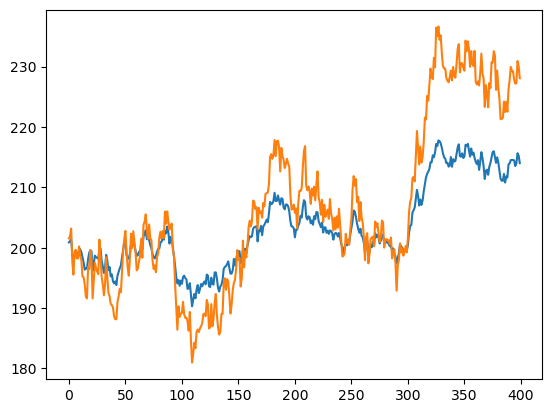

In [2]:
# Create a random seed for consistency
np.random.seed(20)
# Produce a series as the cumulative sum of normally distributed random numbers.
x = np.cumsum(np.random.randn(400)) + 200
# Produce a second series with the same behaviour but higher standard deviation.
y = x*2 + np.random.randn(400) - 200
# Generate an array to be used in our PCA calculation.
# Note that we have to de-mean our values first.
R = np.array([x-np.mean(x),y-np.mean(y)])
# Plot x and y
plt.plot(x)
plt.plot(y)

In [3]:
# Calculate the covariance matrix
S = np.cov(R)
print('Cov Matrix:', S)
# Calculate the eigenvalues and eigenvectors
EIG = np.linalg.eig(S)
print('Eigenvalues: ',EIG[0])
print('Eigenvectors: ',EIG[1])


Cov Matrix: [[ 46.61197617  93.00600641]
 [ 93.00600641 186.48398365]]
Eigenvalues:  [1.81481951e-01 2.32914478e+02]
Eigenvectors:  [[-0.89470603 -0.44665549]
 [ 0.44665549 -0.89470603]]


In [4]:
# Extract the eigenvectors from EIG
EV = EIG[1]
# Create x-values for plotting eigenvectors
xx = np.linspace(min(R[0,:]),max(R[0,:]),200)
# Create y-values for plotting eigenvectors
yy1 = (EV[1][0]/EV[0][0])*xx
yy2 = (EV[1][1]/EV[0][1])*xx

In [5]:
most_significant_factor = np.argmax(EIG[0])
print('Most significant factor: ',most_significant_factor)


Most significant factor:  1


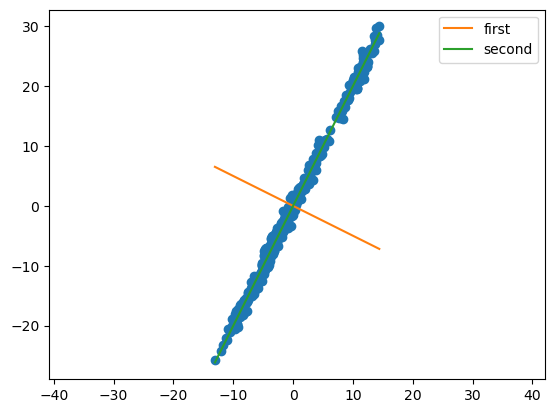

In [6]:
# Plot de-meaned x - y correlation
plt.plot(R[0,:],R[1,:],'o')
# Plot the first principal component
plt.plot(xx,yy1,label='first')
# Plot the second principal component
plt.plot(xx,yy2,label='second')
plt.legend()
# Make sure axis are equal to illustrate orthogonality
plt.axis('equal');

In [7]:
# Calculating the factor values from the eigenvector
factors = np.dot(EV.T,R)


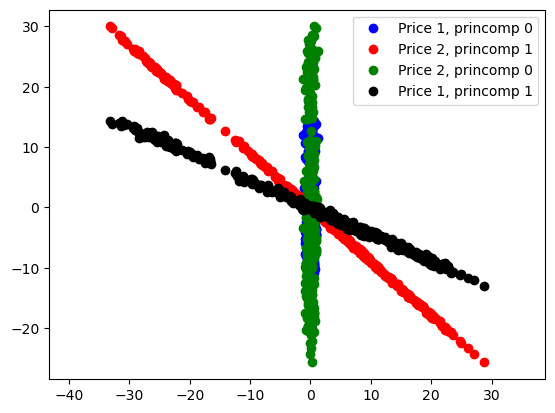

In [8]:
# Correlations between factors
plt.plot(factors[0],R[0,:],'bo',label='Price 1, princomp 0')
plt.plot(factors[1],R[1,:],'ro',label='Price 2, princomp 1')
plt.plot(factors[0],R[1,:],'go',label='Price 2, princomp 0')
plt.plot(factors[1],R[0,:],'ko',label='Price 1, princomp 1')
plt.axis('equal')
plt.legend();


In [9]:
def make_coint_0(N,T0=[0,0],sigma=[1,1],c=[0.1,0.1]):

    X = [0]
    Y = [0]
    for i in range(N):
        rx = np.random.randn()*sigma[0] - c[0]*(X[-1] - Y[-1])
        ry = np.random.randn()*sigma[1] + c[1]*(X[-1] - Y[-1])
        X.append(X[-1]+rx)
        Y.append(Y[-1]+ry)
    return np.array(X)+T0[0],np.array(Y)+T0[1]


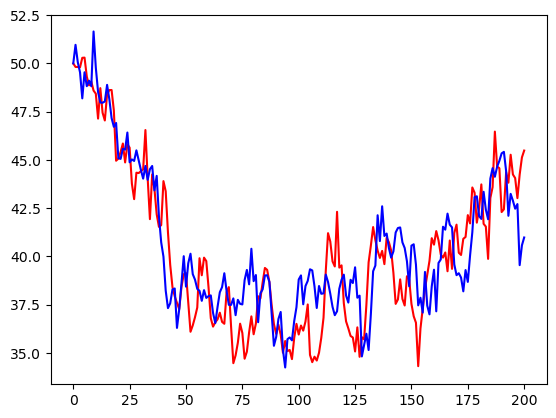

In [10]:
np.random.seed(452)
X,Y = make_coint_0(200,T0=[50,50],c=[0.1,0.1])
plt.plot(X,'r-',Y,'b-');

In [11]:
crit = coint(X,Y)
print('Critical Values:',crit[2])
print('T-statistic:',crit[0])
print('P-value:',crit[1])

Critical Values: [-3.95203768 -3.36685108 -3.065724  ]
T-statistic: -5.574176718429717
P-value: 1.2687688654668578e-05


In [12]:
def Zscore(X):
    return np.array((X - np.mean(X)) / np.std(X))
def run_pca(pr,components=1,log_prices=True):
    # Instanciate PCA
    pca = PCA(n_components=components)
    px = pr.T-np.mean(pr.T)
    if log_prices:
        # Calculate the priciple components using log prices
        comps = pca.fit(np.log(pr.T)).components_.T
        # Create the factors from the pricinple components
        factors = sm.add_constant(pr.T.dot(comps))
    else:
        # Calculate the N priciple components using normal prices
        comps = pca.fit(px).components_.T
        # Create the factors from the pricinple components
        factors = sm.add_constant(px.dot(comps))
        
    # Regress each factor with the actual underlying prices
    mm = [sm.OLS(s.T, factors).fit() for s in pr]
# Calculate the residuals
    resids = list(map(lambda x: x.resid, mm))
    return resids, factors


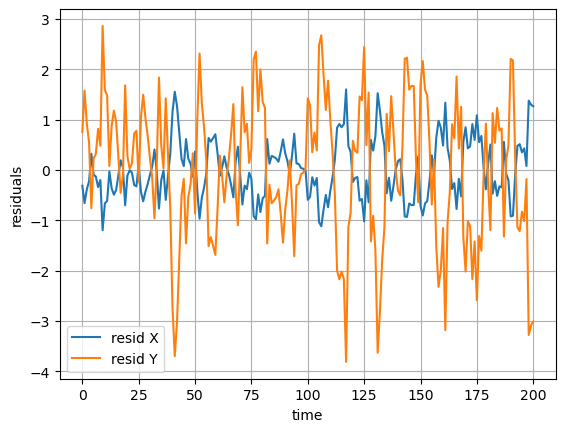

In [13]:
# Create input array from cointegrated price series
R = np.array([X,Y,X])
# Run the PCA calculation
residuals, factors = run_pca(R,log_prices=True)
# Plot the residuals
plt.plot(residuals[0],label='resid X')
plt.plot(residuals[1],label='resid Y')
plt.xlabel('time')
plt.ylabel('residuals')
plt.legend()
plt.grid()


In [14]:
m = np.polyfit(X,Y,1)[0]
m_rev = np.polyfit(Y,X,1)[0]
print('Slope of regression:',m)
print('Inverse slope of reverse regression:',1/m_rev)


Slope of regression: 0.7978929779688265
Inverse slope of reverse regression: 1.0528140853084136
